In [1]:
import torch
from torch import nn, optim

from utils import save_experiment, save_checkpoint
from utils import *
from data_load_CMB_binary import prepare_data
from vit import ViTForClassfication
import matplotlib.pyplot as plt
from utils import visualize_images, visualize_attention

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
exp_name = 'pre-train-vit-with-40-epochs'
batch_size = 256
epochs = 40
lr = 5e-3
save_model_every = 5

config = {
    "patch_size": 15,  # Input image size: 90x90 -> 6x6 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.2,
    "image_size": 90,
    "num_classes": 1,
    "num_channels": 1,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            
            # Zero the gradients
            self.optimizer.zero_grad()
            
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.round(logits)
                correct += (torch.sum(predictions == labels).item())
                
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the  dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size, train_sample_size=100000, test_sample_size=3000)
    # Create the model, optimizer, loss function and trainer
    trained_class = "./experiments/pre-train-vit-with-40-epochs/model_25.pt"
    model = ViTForClassfication(config)
    model.load_state_dict(torch.load(trained_class, map_location=torch.device('cpu')))
    model.eval()
    model = model.to('cuda')
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
    loss_fn = nn.BCELoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device='cuda')
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()

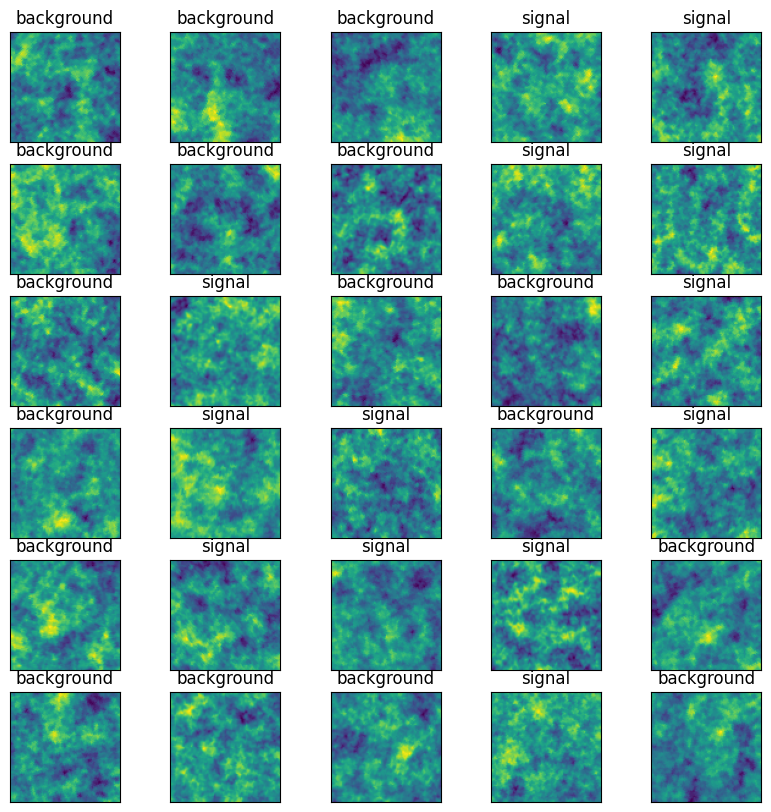

In [5]:
visualize_images()
plt.show()

In [6]:
config, model, train_losses, test_losses, accuracies = load_experiment(f"{exp_name}/",checkpoint_name="model_25.pt")

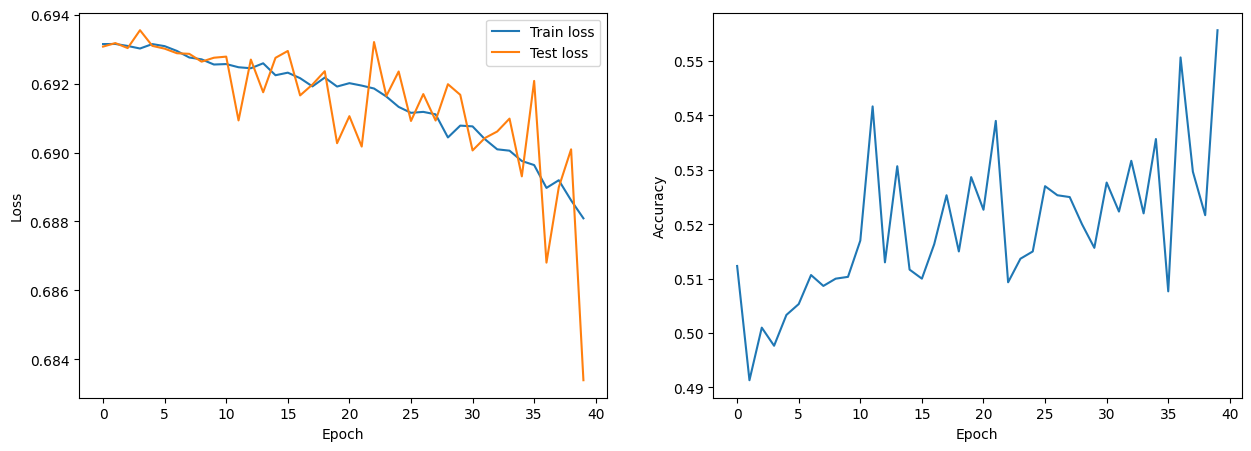

In [22]:
import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
#plt.savefig("metrics.png")
plt.show()

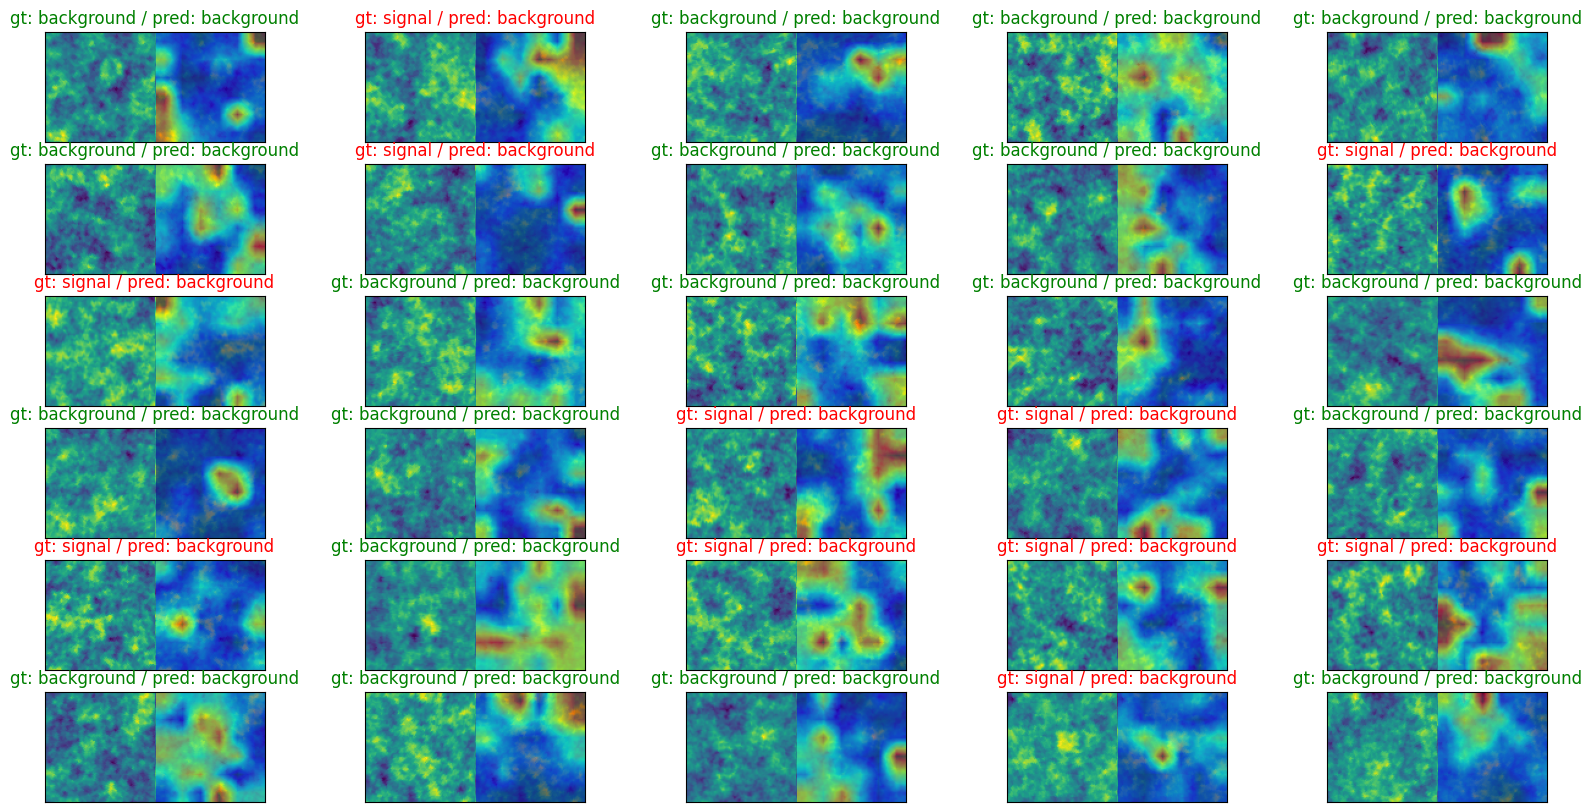

In [12]:
visualize_attention(model, output=None)